In [34]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [36]:
import logging
set_logger(logging.DEBUG)

In [37]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [38]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 25)
(709325, 22)


In [43]:
pp = Preprocess(df_transaction, df_property)

In [44]:
use_features = pp.get_feature_list()

In [45]:
# records of last year
#use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(64735, 14)

In [46]:
monthly_volume = int(df_track.shape[0] / 24)
df_track.head()

,lat,sqft_price_zip_avg,pool,num_bath,sqft_zip_avg,lon,view,num_bed,sqft,sold_price,id,sold_price_zip_avg,date,impr_over_land
0,32.93745,334.725439,0,2.0,2162.542982,-117.10164,0,2.0,1064,346500,1428580,698046.052632,2015-10-01,1.015708
39987,33.21985,241.821715,1,3.0,1908.309068,-117.10536,1,5.0,3790,842500,1428661,443836.520666,2015-10-01,1.890077
18276,33.15343,259.656908,0,1.0,1851.554437,-117.19728,0,2.0,827,265000,1428593,460152.790485,2015-10-01,1.934843
51748,32.62687,246.869369,0,2.0,1483.899399,-117.05104,0,3.0,1459,417500,1428713,354269.144144,2015-10-01,0.967124
51747,32.61402,246.869369,0,1.0,1483.899399,-117.08126,0,2.0,814,175000,1428664,354269.144144,2015-10-01,1.357232


## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [47]:
### segment on sold_price
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[df_track['sold_price']<1000000]
mm = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)

[dp] track/sliding/test window size: 49857, 32364, 10788
[dp] train/valid/test size: 39885, 9972, 10788
[dp] validation step is skipped


71779.91882577594

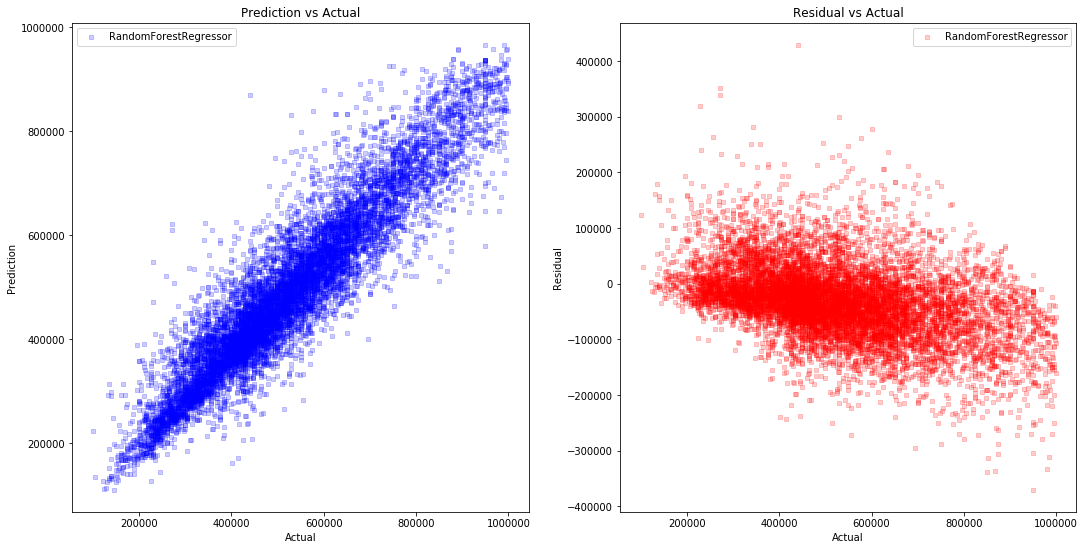

In [49]:
mm.plot_residual()

In [50]:
#df_check = mm.get_result_df(pp)
df_check = pp.debug(mm.get_result_df())

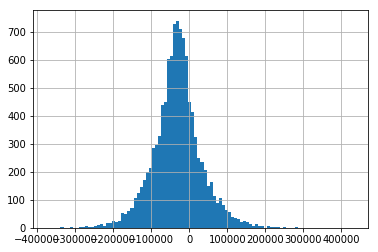

In [51]:
df_check[df_check['residual']<500000]['residual'].hist(bins=100)

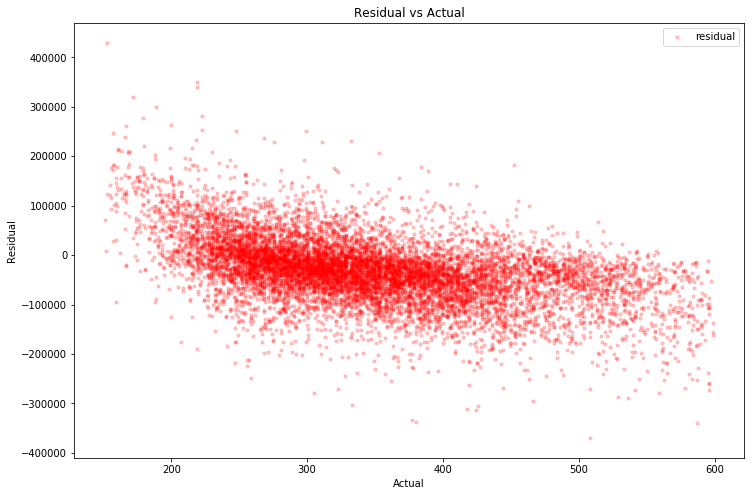

In [52]:
plt.figure(figsize=(12,8))
plt.scatter(df_check['sqft_price'], df_check['residual'], s=10, c='r', alpha=0.2)
plt.xlabel('Actual')
plt.ylabel('Residual')
plt.legend(loc='best');
plt.title('Residual vs Actual')

plt.show()

In [18]:
def remeasure(df_check, threshold=200000):
    removed = df_check[df_check['residual']>=threshold]
    print("removed records:", removed.shape[0])
    df_left = df_check[df_check['residual']<threshold]
    return sqrt(mean_squared_error(df_left['predict'], df_left['sold_price']))

In [19]:
remeasure(df_check)

removed records: 57


76854.96974047921

In [154]:
df_check[df_check['residual']>=200000]

,str_no,street,st_type,city,zip,lon,lat,sqft,sold_price,predict,residual,date,pin,land_use_subcode
16,526,DURHAM,ST,EL CAJON,92019,-116.92572,32.80076,2075,343000,560785.934842,217785.934842,2017-05-30,5110500500,11
145,940,LA RUEDA,DR,VISTA,92084,-117.19774,33.19456,2606,425000,677736.983754,252736.983754,2017-05-31,1810411600,11
426,3098,RUE D ORLEANS,None,SAN DIEGO,92110,-117.22822,32.75264,1263,37500,499825.326139,462325.326139,2017-06-01,4410902644,17
450,1907,ROBINSON,AVE,SAN DIEGO,92104,-117.14480,32.74635,1008,37500,651847.447996,614347.447996,2017-06-01,4531811302,17
739,138,MASON,RD,VISTA,92084,-117.24200,33.24255,3491,522500,807912.859668,285412.859668,2017-06-05,1701227200,11
1448,10806,EBERLY,CT,SAN DIEGO,92126,-117.12752,32.91768,1599,319000,545705.740278,226705.740278,2017-06-13,3184002900,11
1710,3785,IBIS,ST,SAN DIEGO,92103,-117.17305,32.74718,1559,632000,854284.781753,222284.781753,2017-06-15,4510500600,11
1753,10215,PINETREE,DR,SAN DIEGO,92131,-117.10153,32.90710,2802,530000,819705.592423,289705.592423,2017-06-15,3632020300,11
1907,10042,DIVERSION,DR,SPRING VALLEY,91977,-116.97629,32.74186,1372,70000,395546.287443,325546.287443,2017-06-16,5050710900,11
1911,7241,HORNER,ST,SAN DIEGO,92120,-117.06513,32.79646,2994,650000,851541.956333,201541.956333,2017-06-16,6721700400,11


In [30]:
df_track['sqft_price']

KeyError: 'sqft_price'

In [29]:
### segment on sold_price
rf = RandomForestRegressor(n_estimators=100, max_depth=14, n_jobs=-1, random_state=17)
df_track_filter = df_track[(df_track['sqft_price']>150) & (df_track['sqft_price']<600)]
mm = ModelManager(df_track_filter, use_features, rf, time_series=True)
mm.run(sliding_window=monthly_volume*12, test_size=monthly_volume*4)
mm.plot_residual()

KeyError: 'sqft_price'